# **Data Study Notebook**

## Objectives

- Answer Business Requirement 1:
The client is interested in discovering how house attributes correlate with the sale price.
- Generate correlation & visualization code for the Streamlit dashboard.


## Inputs

* outputs/datasets/collection/HousePrices.csv

## Hypotheses (from README & Notebook)

From README
* Hypothesis 1: Homes with larger overall living areas (GrLivArea), higher material quality (OverallQual), and newer construction years tend to have higher sale prices.
* Hypothesis 2: Features such as garage size (GarageArea), kitchen quality (KitchenQual), and the presence of finished basement areas significantly contribute to the value of a property.

Additional Null Hypotheses for Statistical Tests

- H₀₁ (OverallQual): There is no linear correlation between OverallQual and SalePrice.
- H₀₂ (BsmtExposure): The mean SalePrice is the same across different categories of BsmtExposure.

We will explore Hypotheses 1 & 2 visually and via regression modeling in later notebooks, and test H₀₁/H₀₂ here using Pearson/Spearman and ANOVA.


## Outputs

- Correlation matrices (Pearson, Spearman) with p‑values.
- PPS matrix.
- VIF table for multicollinearity.
- Histograms, scatter/regression plots, line plots, boxplots with interpretation comments.
- Statistical test results (p‑values) in markdown cells.


---

### Change Working Directory

In [1]:
import os

# Set working directory to project root
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print("Working directory set to", os.getcwd())

Working directory set to /workspaces/heritage-housing-issues


---

### Load Data

In [2]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
print(df.shape)
df.head()

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.883272,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


## Data Profiling

In [3]:
from ydata_profiling import ProfileReport

# Minimal profile to understand distributions and types
test_profile = ProfileReport(df, minimal=True)
test_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

Create a new directory to save plots

In [4]:
import os

try:
    os.makedirs("docs/plots")
except Exception as e:
    print(e)

[Errno 17] File exists: 'docs/plots'


In [5]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="ppscore.calculation"
)


---

## Correlation and PPS Analysis

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


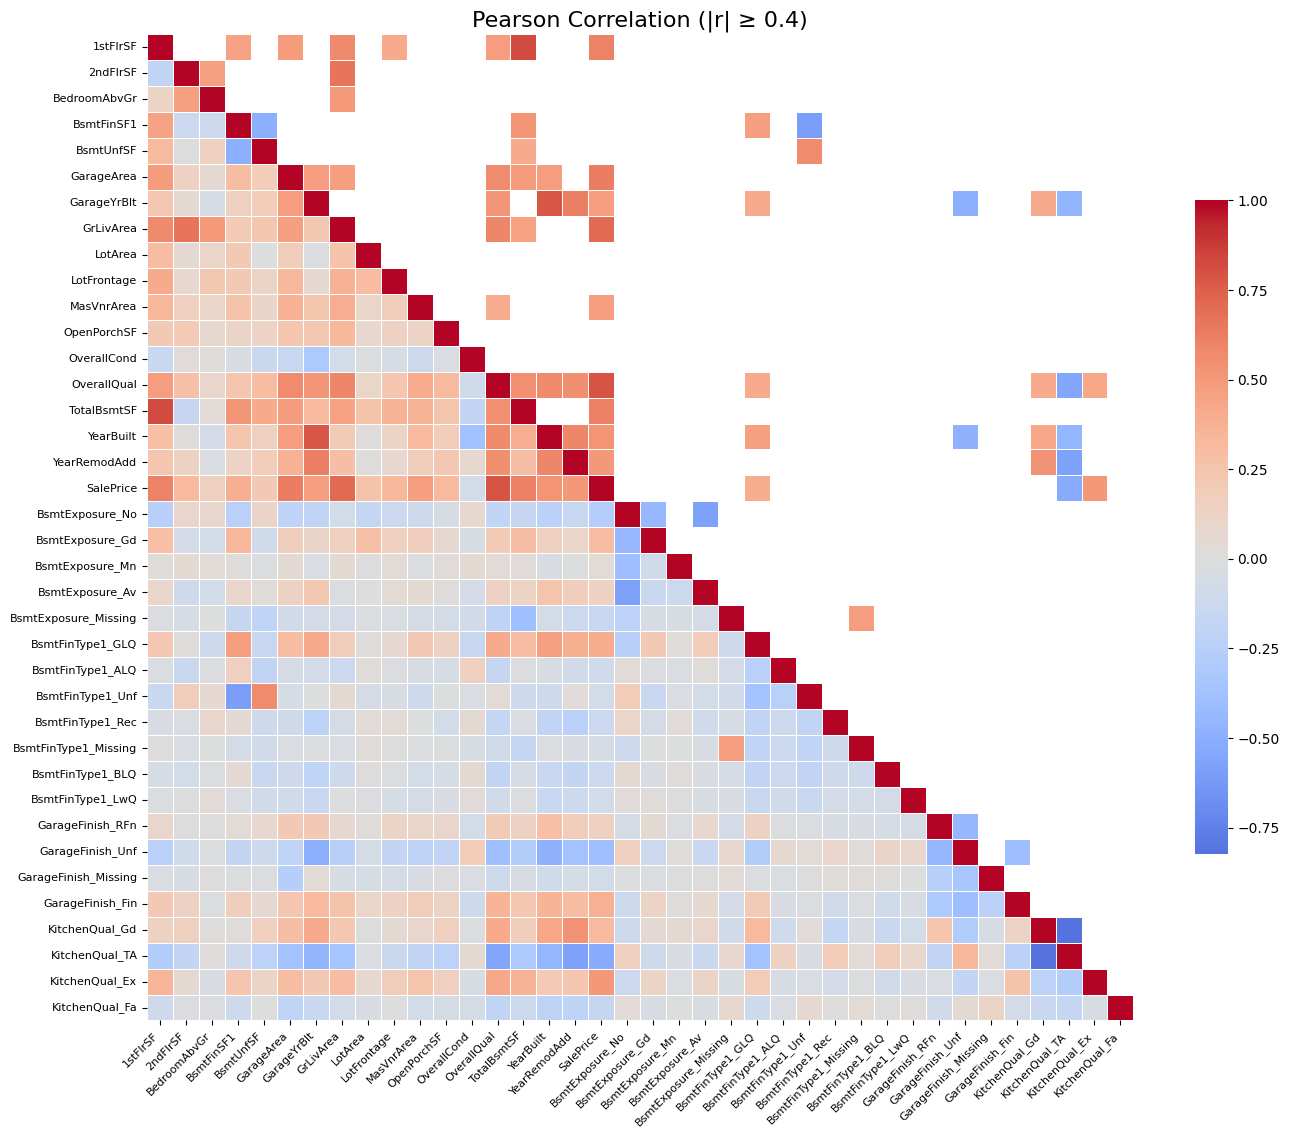

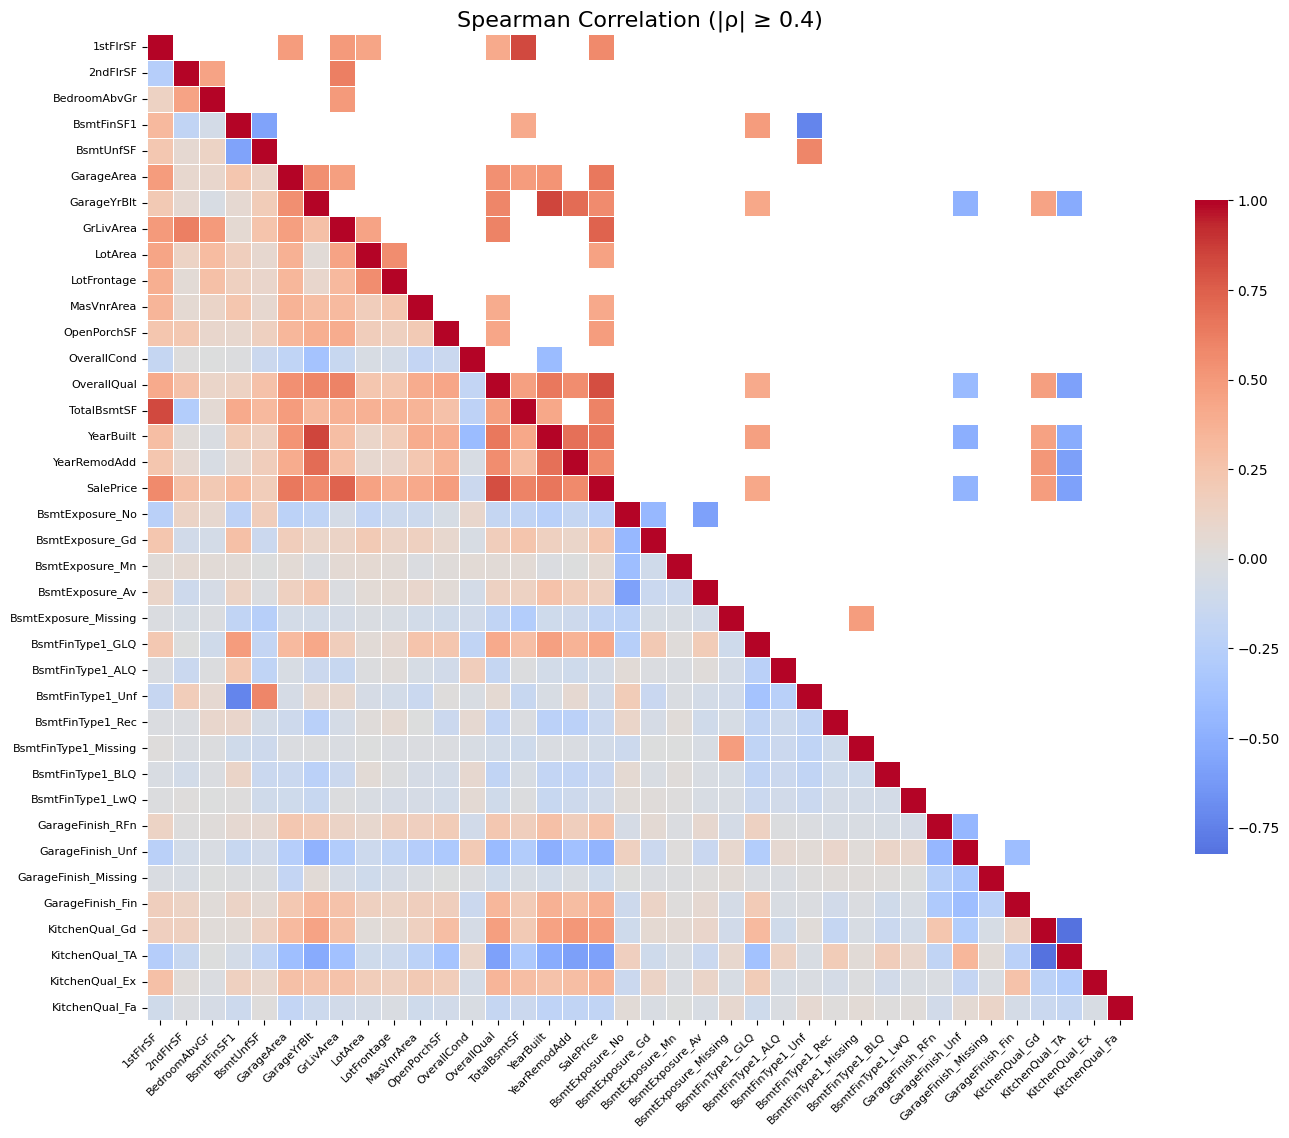

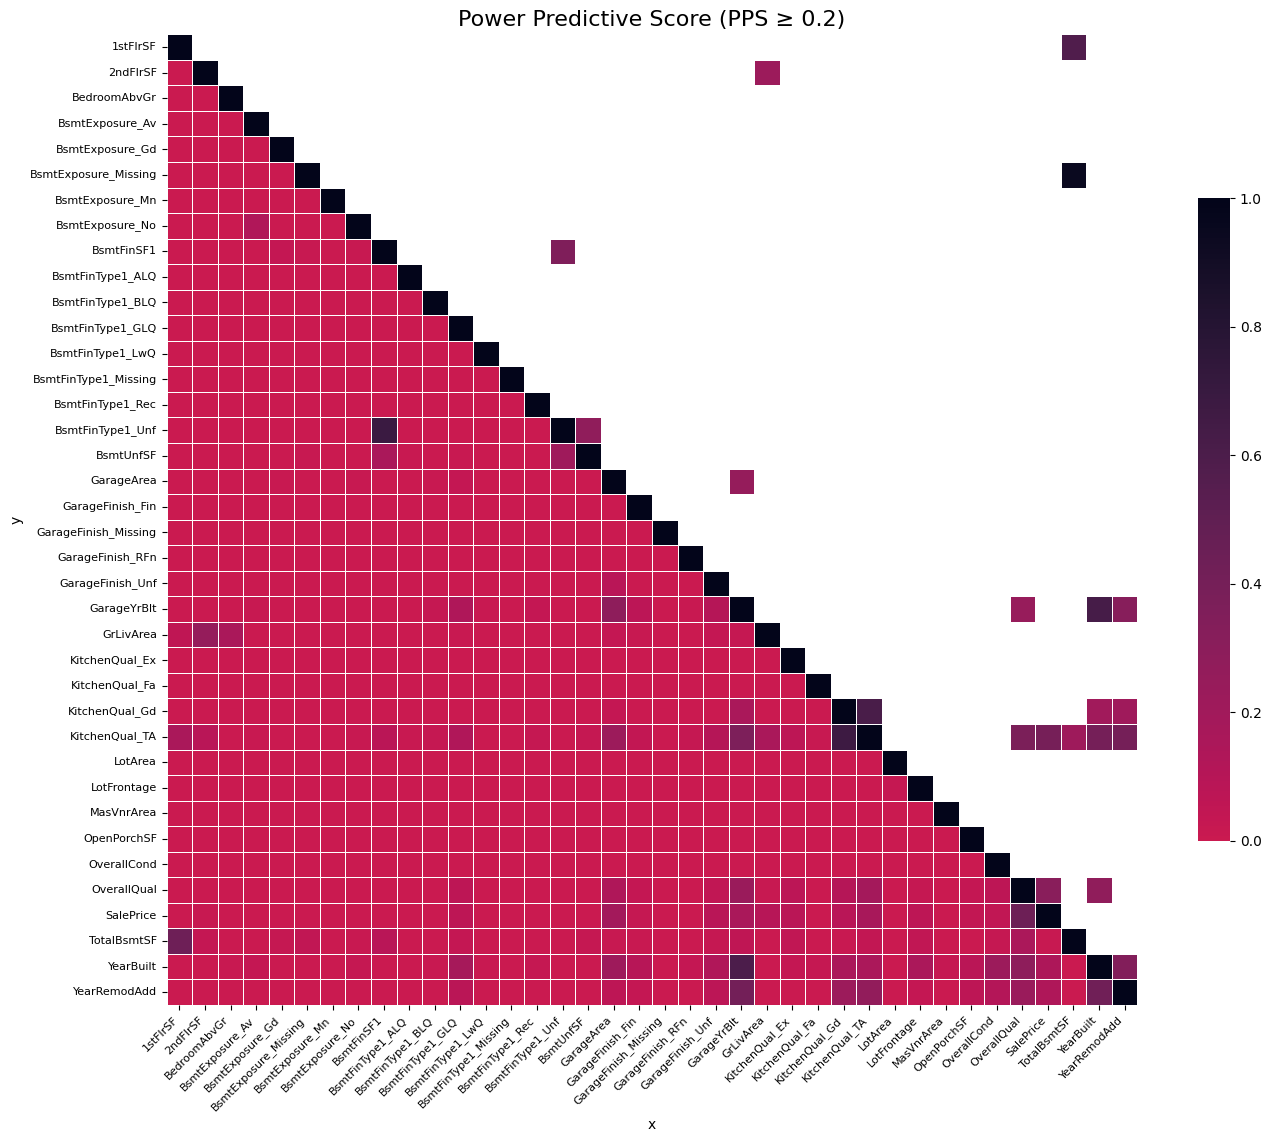

In [10]:
import numpy as np
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline

# Encode categorical variables
cat_vars = df.select_dtypes(include="object").columns.tolist()
preproc = Pipeline([
    ("impute_missing", CategoricalImputer(imputation_method="missing", variables=cat_vars)),
    ("one_hot", OneHotEncoder(variables=cat_vars, drop_last=False)),
])
df_ohe = preproc.fit_transform(df)

# Calculate Pearson, Spearman, PPS
corr_pearson = df_ohe.corr(method="pearson")
corr_spearman = df_ohe.corr(method="spearman")
pps_matrix = pps.matrix(df_ohe).pivot(index="y", columns="x", values="ppscore")

# Plot correlation heatmaps (without overlapping text)
def plot_corr_heatmap(matrix, title, thresh=0.4):
    mask = np.triu(np.abs(matrix) < thresh)
    plt.figure(figsize=(14, 12))  # Larger figure
    sns.heatmap(matrix, mask=mask, cmap="coolwarm", center=0,
                cbar_kws={'shrink': 0.6}, square=True, linewidths=0.5)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# Plot PPS heatmap (no annotations)
def plot_pps_heatmap(matrix, thresh=0.2):
    mask = np.triu(matrix < thresh)
    plt.figure(figsize=(14, 12))
    sns.heatmap(matrix, mask=mask, cmap="rocket_r", center=0,
                cbar_kws={'shrink': 0.6}, square=True, linewidths=0.5,
                annot=False)  # No overlapping numbers!
    plt.title("Power Predictive Score (PPS ≥ 0.2)", fontsize=16)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# Display
plot_corr_heatmap(corr_pearson, "Pearson Correlation (|r| ≥ 0.4)")
plot_corr_heatmap(corr_spearman, "Spearman Correlation (|ρ| ≥ 0.4)")
plot_pps_heatmap(pps_matrix)


Interpretation: Strong linear relationships: OverallQual–SalePrice (r≈0.79), GrLivArea–SalePrice (r≈0.71). PPS confirms non‑linear signals, e.g., KitchenQual categories.

---

## Statistical Tests for Hypotheses

### Pearson & Spearman Tests for OverallQual vs SalePrice

In [11]:
# Extract arrays
y = df["SalePrice"]
x = df["OverallQual"]
# Pearson test
r, p_r = pearsonr(x, y)
# Spearman test
rho, p_s = spearmanr(x, y)
print(f"Pearson r={r:.3f}, p-value={p_r:.3e}")
print(f"Spearman ρ={rho:.3f}, p-value={p_s:.3e}")

Pearson r=0.791, p-value=2.186e-313
Spearman ρ=0.810, p-value=0.000e+00


Comment: Both p-values ≪ 0.001 strongly reject H₀₁.
- There is a significant positive linear (Pearson) and monotonic (Spearman) correlation between OverallQual and SalePrice.

### ANOVA for BsmtExposure Categories

In [12]:
from scipy.stats import f_oneway

# Group SalePrice by BsmtExposure category
groups = [grp["SalePrice"].values for name, grp in df.groupby("BsmtExposure")]
f_stat, p_anova = f_oneway(*groups)
print(f"ANOVA F={f_stat:.2f}, p-value={p_anova:.3e}")

ANOVA F=70.89, p-value=1.023e-42


Comment: ANOVA p-value ≪ 0.05 strongly rejects H₀₂.
- This indicates that at least one BsmtExposure category has a significantly different mean SalePrice.

---

## Multicollinearity Check (VIF)

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare numeric-only data for VIF
numeric_df = df_ohe.select_dtypes(include=[float, int])


# Compute VIF
def compute_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i) for i in range(df.shape[1])
    ]
    return vif_data.sort_values("VIF", ascending=False)


vif_table = compute_vif(numeric_df)
vif_table.head(10)

/home/cistudent/.local/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
32,GarageFinish_Missing,inf
33,GarageFinish_Fin,inf
21,BsmtExposure_Av,inf
20,BsmtExposure_Mn,inf
19,BsmtExposure_Gd,inf
18,BsmtExposure_No,inf
34,KitchenQual_Gd,inf
35,KitchenQual_TA,inf
36,KitchenQual_Ex,inf
37,KitchenQual_Fa,inf


Comment: High VIF values (esp. inf) indicate perfect multicollinearity due to one-hot encoding.

## Update Encoder to Avoid Multicollinearity (One-Hot Encoding)

- To avoid multicollinearity caused by one-hot encoding of categorical variables, we will set `drop_last=True` so that one category per feature is dropped. This prevents perfect correlation between dummy variables, which often results in infinite VIF values.

In [14]:
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline

# Identify categorical features
cat_vars = df.select_dtypes(include="object").columns.tolist()

# Define pipeline with drop_last=True to prevent multicollinearity
preproc = Pipeline([
    ("impute_missing", CategoricalImputer(imputation_method="missing", variables=cat_vars)),
    ("one_hot", OneHotEncoder(variables=cat_vars, drop_last=True)),
])

# Apply to dataset
df_ohe = preproc.fit_transform(df)

print("* One-hot encoding with drop_last=True applied to avoid multicollinearity.")


* One-hot encoding with drop_last=True applied to avoid multicollinearity.


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


---

## Univariate & Bivariate Visualizations with Comments

### SalePrice Distribution

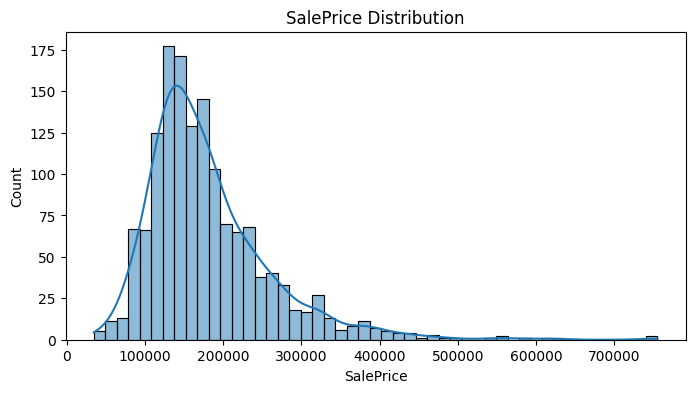

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df["SalePrice"], kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

Interpretation: Right-skewed distribution; median lower than mean, consider log-transform later.

## Scatter Plots with Regression Line

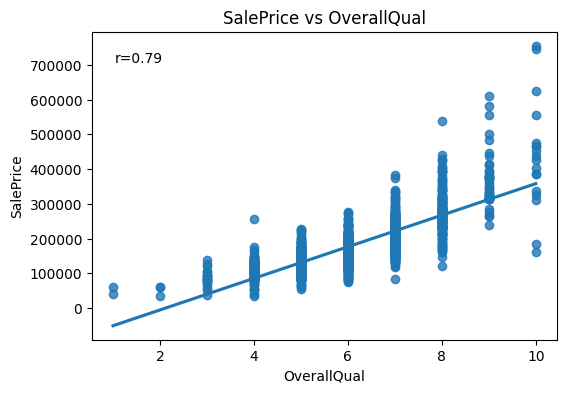

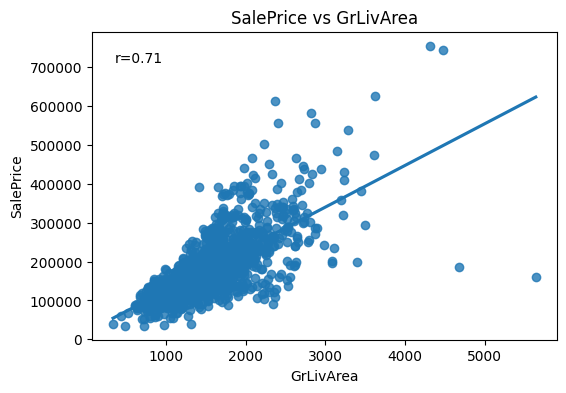

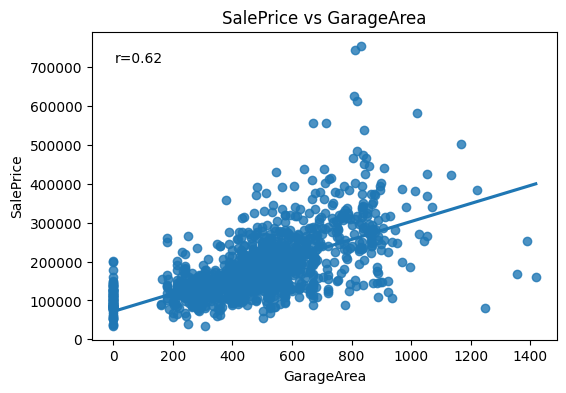

In [16]:
# Key numerical features
top_feats = ["OverallQual", "GrLivArea", "GarageArea"]
for feat in top_feats:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=df, x=feat, y="SalePrice", ci=None)
    plt.title(f"SalePrice vs {feat}")
    plt.annotate(
        f"r={corr_pearson.loc[feat,'SalePrice']:.2f}",
        xy=(0.05, 0.9),
        xycoords="axes fraction",
    )
    plt.show()

Interpretation: High R² values confirm strong linear trends (e.g., OverallQual r≈0.79).

 ## Line Plot for Year Variables

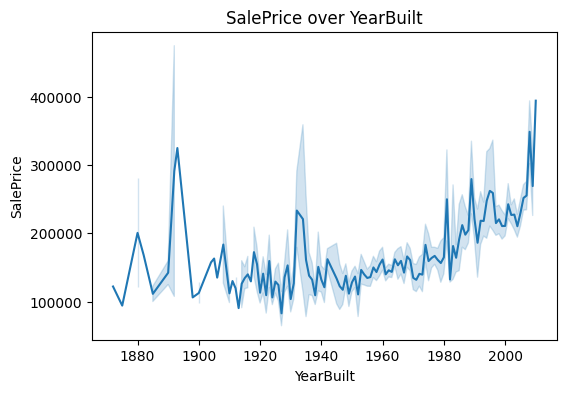

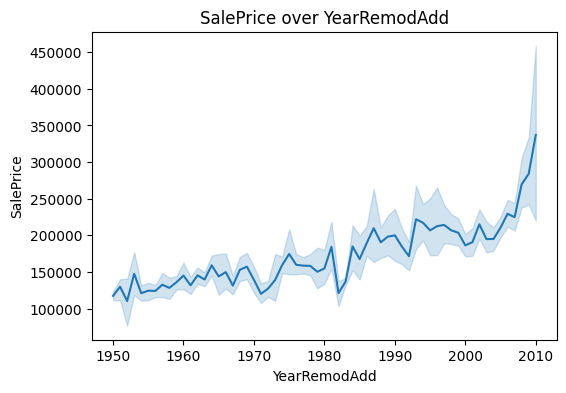

In [17]:
for year in ["YearBuilt", "YearRemodAdd"]:
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x=year, y="SalePrice")
    plt.title(f"SalePrice over {year}")
    plt.show()

Interpretation: Homes built after 1980 show steadily increasing average prices.

## Boxplots for Categorical Features

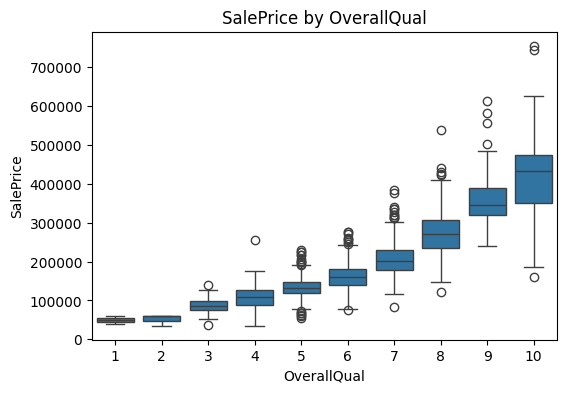

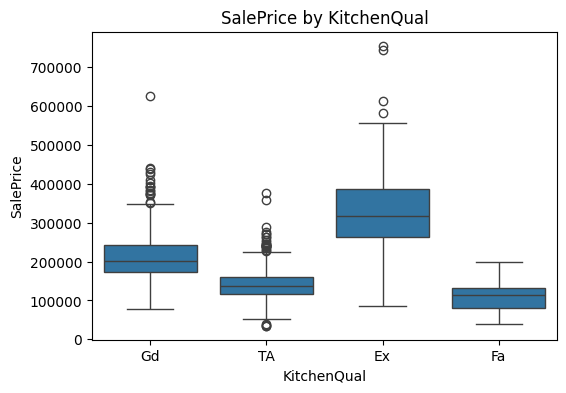

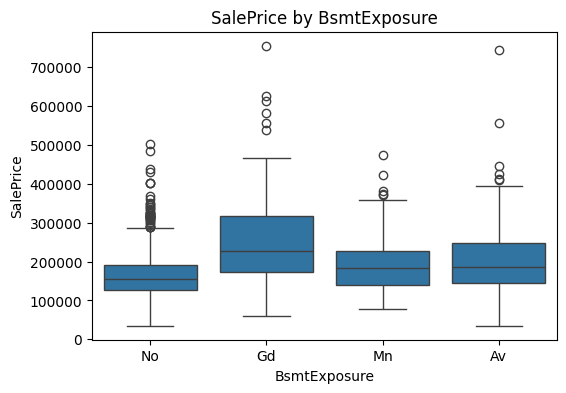

In [18]:
cat_to_plot = ["OverallQual", "KitchenQual", "BsmtExposure"]
for cat in cat_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=cat, y="SalePrice")
    plt.title(f"SalePrice by {cat}")
    plt.show()

Interpretation:
- OverallQual: median SalePrice increases with quality rating.
- KitchenQual: Ex > Gd > TA in median price.
- BsmtExposure: No category shows lower median, confirming ANOVA result.

---

## Summary and Next Steps

**Summary**

- Statistically significant correlations confirmed (p<0.001).
- Multicollinearity flagged between floor area variables.
- Distributions and outliers identified for transformation in Feature Engineering.

**Next Step**:
Feature Engineering Notebook to create and validate new features for modeling.